In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### Create model and train

In [7]:
def convert_distance_to_probability(distances, a, b):
    """ convert distance representation into probability, 
        as a function of a, b params
    """
    return 1.0 / (1.0 + a * distances ** (2 * b))


def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    """
    Compute cross entropy between low and high probability

    Parameters
    ----------
    probabilities_graph : [type]
        high dimensional probabilities
    probabilities_distance : [type]
        low dimensional probabilities
    EPS : [type], optional
        offset to to ensure log is taken of a positive number, by default 1e-4
    repulsion_strength : float, optional
        strength of repulsion between negative samples, by default 1.0

    Returns
    -------
    attraction_term: tf.float32
        attraction term for cross entropy loss
    repellant_term: tf.float32
        repellant term for cross entropy loss
    cross_entropy: tf.float32
        cross entropy umap loss
    
    """
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE


def remove_redundant_edges(graph):
    """
    Removes redunancies in graph
    """
    edges = graph.nonzero()
    # remove redundancies
    redundant_edges = edges[0] <= edges[1]
    edges = (edges[0][redundant_edges], edges[1][redundant_edges])
    # reconstruct graph
    graph = csr_matrix(
        (np.array(graph[edges]).flatten(), (edges[0], edges[1])), shape=graph.shape
    )
    return graph


def get_graph_elements(graph_, n_epochs):
    """
    gets elements of graphs, weights, and number of epochs per edge

    Parameters
    ----------
    graph_ : [type]
        umap graph of probabilities
    n_epochs : int
        maximum number of epochs per edge

    Returns
    -------
    graph [type]
        umap graph
    epochs_per_sample np.array
        number of epochs to train each sample for
    head np.array
        edge head
    tail np.array
        edge tail
    weight np.array
        edge weight
    n_vertices int
        number of verticies in graph
    """
    ### should we remove redundancies () here??
    # graph_ = remove_redundant_edges(graph_)

    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices




In [8]:
# base umap embedding with tensorflow
# Author: Tim Sainburg

import tensorflow as tf
import numpy as np
from tfumap.base import UMAP_tensorflow
from tqdm.autonotebook import tqdm
import os
import pandas as pd
import tempfile
import pickle
from pathlib2 import Path
import codecs
from numba import TypingError

tf.get_logger().setLevel("INFO")

from umap.umap_ import make_epochs_per_sample
from scipy.sparse import csr_matrix

from datetime import datetime
from sklearn.utils import check_random_state
from sklearn.neighbors import KDTree
import joblib
from umap.utils import ts
from umap.spectral import spectral_layout

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


class tfUMAP(UMAP_tensorflow):
    def __init__(
        self,
        optimizer=None,
        tensorboard_logdir=None,  # directory for tensorboard log
        batch_size=None,  # size of batch used for batch training
        dims=None,  # dimensionality of data, if not flat (e.g. images for ConvNet)
        negative_sample_rate=2,  # how many negative samples per positive samples for training
        max_sample_repeats_per_epoch=None,  # (setting this value to 1 is equivalent to computing UMAP on nearest neighbors graph without fuzzy_simplicial_set)
        direct_embedding=False,  # whether to learn embeddings directly, or use neural network
        encoder=None,  # the neural net used for encoding (defaults to 3 layer 100 neuron fc)
        decoder=None,  # the neural net used for decoding (defaults to 3 layer 100 neuron fc)
        training_epochs=None,  # number of epochs to train for ()
        decoding_method=None,  # how to decode "autoencoder", "network", or None
        valid_X=None,  # validation data for reconstruction and classification error
        valid_Y=None,  # validation labels for reconstruction and classification error
        umap_loss_weight=1.0,  # weight for the umap loss
        reconstruction_loss_weight=1.0,  # weight for the reconstruction loss
        **kwargs
    ):
        """ UMAP in tensorflow. 
        Subclass of UMAP that performs embeddings using tensorflow. 

        Parameters
        ----------
        optimizer : tf.keras.optimizers, optional
            The tensorflow optimizer used for embedding. Usually ADAM for neural nets
            and adadelta for direct optimization, by default None
        tensorboard_logdir : str, optional
            Location to place tensorboard logs, by default None
        batch_size : int, optional
            size of batch used for batch training, by default None
        dims : tuple, optional
            dimensionality of data, if not flat (e.g. images for ConvNet), by default None
        negative_sample_rate : int, optional
            How many negative samples per positive samples for training, by default 2
        max_sample_repeats_per_epoch : int, optional
            maximum number of times each edge can be sampled for one epoch (setting this value to
             1 is equivalent to computing UMAP on nearest neighbors graph without 
             fuzzy_simplicial_set), by default None
        direct_embedding : bool, optional
            whether to learn embeddings directly, or use neural network, by default False
        encoder : tf.keras.Sequential, optional
            the neural net used for encoding (defaults to 3 layer 100 neuron fc), by default None
        decoder : tf.keras.Sequential, optional
            the neural net used for decoding (defaults to 3 layer 100 neuron fc), by default None
        training_epochs : int, optional
            number of epochs to train for. Seperate from n_epochs, which here is used for determining
            the number of training samples per edge based on probability., by default 50
        decoding_method : string, optional (default None)
            how to decode. Options are:
                * "autoencoder"
                * "network"
                * None
        valid_X : np.array, optional
            validation data for reconstruction error, by default None
        valid_Y : np.array, optional
            validation labels for reconstruction error, by default None
        umap_loss_weight : float, optional
            weight for the umap loss, by default 1.0
        reconstruction_loss_weight : float, optional
            weight for the reconstruction loss, by default 1.0
        """
        # retrieve everything from base model
        super().__init__(**kwargs)

        self.batch_size = batch_size

        self.max_sample_repeats_per_epoch = max_sample_repeats_per_epoch  # maximum number of repeated edges during training

        # set weights for each loss component
        self.reconstruction_loss_weight = reconstruction_loss_weight
        self.umap_loss_weight = umap_loss_weight

        # set optimizer, Adam is better for neural networks, Adadelta is better for direct embedding
        if optimizer is None:
            if direct_embedding:
                self.optimizer = tf.keras.optimizers.Adadelta(50)
            else:
                self.optimizer = tf.keras.optimizers.Adam(1e-3)
        else:
            self.optimizer = optimizer

        self.random_state = check_random_state(None)

        self.dims = dims  # if this is an image, we should reshape for network
        self.encoder = encoder  # neural network used for embedding
        self.decoder = decoder  # neural network used for decoding
        # whether to use a decoder, and what type  ("autoencoder", "network", None)
        self.decoding_method = decoding_method

        # whether to encode with encoder, or embed directly
        self.direct_embedding = direct_embedding

        self.valid_X = valid_X  # validation data used for reconstruction
        # TODO valid_Y is not needed without a classifier
        self.valid_Y = valid_Y  # validation labels used for

        # make a binary cross entropy object for reconstruction
        if self.decoding_method in ["autoencoder", "network"]:
            self.binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

        # number of training epochs. Different than n_epochs for base model
        #   (which is still used, e.g. for embedding using original method)
        self.training_epochs = training_epochs

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

    def compute_umap_loss(self, batch_to, batch_from):
        """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """

        if self.direct_embedding:
            # get the embeddings
            embedding_to = tf.gather(self.embedding, batch_to)
            embedding_from = tf.gather(self.embedding, batch_from)
        else:
            # encode
            embedding_to = self.encoder(batch_to)
            embedding_from = self.encoder(batch_from)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, self.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, self.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self._a, self._b
        )

        # treat positive samples as p=1, and negative samples as p=0
        probabilities_graph = tf.concat(
            [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])],
            axis=0,
        )

        # cross entropy loss
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self.repulsion_strength,
        )

        return ce_loss, embedding_to, embedding_from


    @tf.function
    def train_batch(self, batch_to, batch_from):
        """
        One training step for embedding / reconstructing 

        Parameters
        ----------
        batch_to : [type]
            either data, or indices of data (if direct_embedding)
        batch_from : [type]
            either data, or indices of data (if direct_embedding)
        Returns
        -------
        umap_loss
            cross entropy loss for umap
        reconstruction_loss
            cross entropy loss for reconstruction
        """
        with tf.GradientTape() as tape:
            # all methods get UMAP loss
            umap_loss, embedding_to, embedding_from = self.compute_umap_loss(
                batch_to, batch_from
            )
            # get reconstruction loss if applicable
            if self.decoding_method == "autoencoder":

                # grab X data if using a direct embedding
                if self.direct_embedding:
                    # get the embeddings
                    batch_to = tf.gather(self._raw_data, batch_to)
                    batch_from = tf.gather(self._raw_data, batch_from)

                umap_loss = tf.reduce_mean(umap_loss)
                reconstruction_loss = tf.reduce_mean(
                    [
                        self.compute_reconstruction_loss(batch_to, embedding_to),
                        self.compute_reconstruction_loss(batch_from, embedding_from),
                    ]
                )
            elif self.decoding_method == "network":
                # grab X data if using a direct embedding
                if self.direct_embedding:
                    # get the embeddings
                    batch_to = tf.gather(self._raw_data, batch_to)
                    batch_from = tf.gather(self._raw_data, batch_from)

                umap_loss = tf.reduce_mean(umap_loss)
                # the same loss as autoencoder, but stopping the gradient before the embedding
                reconstruction_loss = tf.reduce_mean(
                    [
                        self.compute_reconstruction_loss(
                            batch_to, tf.stop_gradient(embedding_to)
                        ),
                        self.compute_reconstruction_loss(
                            batch_from, tf.stop_gradient(embedding_from)
                        ),
                    ]
                )
            else:
                reconstruction_loss = 0.0

            loss = (
                umap_loss * self.umap_loss_weight
                + reconstruction_loss * self.reconstruction_loss_weight
            )

            grads = tape.gradient(loss, self.training_variables)
            grads = [tf.clip_by_value(grad, -4.0, 4.0) * self.alpha for grad in grads]
            self.optimizer.apply_gradients(zip(grads, self.training_variables))

        return umap_loss, reconstruction_loss

    def batch_epoch_edges(self, edges_to, edges_from):
        """ permutes and batches edges for epoch
        """
        # compute the number of batches in one epoch
        n_batches = int(len(edges_to) / self.batch_size)
        # permute list of edges
        permutation_mask = np.random.permutation(len(edges_to))[
            : n_batches * self.batch_size
        ]
        to_all = tf.reshape(
            tf.gather(edges_to, permutation_mask), (n_batches, self.batch_size)
        )
        from_all = tf.reshape(
            tf.gather(edges_from, permutation_mask), (n_batches, self.batch_size)
        )
        # return a tensorflow dataset of one epoch's worth of batches
        return tf.data.Dataset.from_tensor_slices((to_all, from_all))

    def create_edge_iterator(self, head, tail, weight):
        """ create an iterator for edges
        """
        # set the maximum number of times each edge should be repeated per epoch
        if self.max_sample_repeats_per_epoch is None:
            self.max_sample_repeats_per_epoch = 25
        epochs_per_sample = np.clip(
            (weight / np.max(weight)) * self.max_sample_repeats_per_epoch,
            1,
            self.max_sample_repeats_per_epoch,
        ).astype("int")

        edges_to_exp, edges_from_exp = (
            np.array([np.repeat(head, epochs_per_sample.astype("int"))]),
            np.array([np.repeat(tail, epochs_per_sample.astype("int"))]),
        )
        edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
        edge_iter = edge_iter.repeat()
        edge_iter = edge_iter.map(self.batch_epoch_edges)
        edge_iter = edge_iter.prefetch(buffer_size=10)

        return iter(edge_iter), np.shape(edges_to_exp)[1]

    def init_embedding_from_graph(self, graph, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = self.random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], self.n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                self._raw_data,
                graph,
                self.n_components,
                self.random_state,
                metric=self.metric,
                metric_kwds=self._metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + self.random_state.normal(
                scale=0.0001, size=[graph.shape[0], self.n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + self.random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

    def prepare_networks(self):
        """
        Generates networks for embedding, reconstruction. Gets a list of
        trainable variables for training step. 
        """
        if self.direct_embedding:
            self.training_variables = [self.embedding]
        else:
            # create an encoder network, if one does not exist
            if self.encoder is None:
                self.encoder = tf.keras.Sequential()
                self.encoder.add(tf.keras.layers.InputLayer(input_shape=self.dims))
                self.encoder.add(tf.keras.layers.Flatten())
                self.encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
                self.encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
                self.encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
                self.encoder.add(
                    tf.keras.layers.Dense(units=self.n_components, name="z")
                )

            # get list of trainable variables for gradient descent
            self.training_variables = self.encoder.trainable_variables

        if (self.decoding_method in ["autoencoder", "network"]) & (
            self.decoder is None
        ):
            self.decoder = tf.keras.Sequential()
            self.decoder.add(tf.keras.layers.InputLayer(input_shape=self.n_components))
            self.decoder.add(tf.keras.layers.Flatten())
            self.decoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
            self.decoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
            self.decoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
            self.decoder.add(
                tf.keras.layers.Dense(units=np.product(self.dims), activation="sigmoid")
            )
            self.decoder.add(tf.keras.layers.Reshape(self.dims))

        if self.decoding_method in ["autoencoder", "network"]:
            self.training_variables += self.decoder.trainable_variables

    def create_validation_iterator(self):
        """ Create an iterator that returns validation X and Y
        """
        # create a Y validation dataset if one doesn't exist
        if self.valid_Y is None:
            self.valid_Y = np.zeros(len(self.valid_X)) - 1

        data_valid = tf.data.Dataset.from_tensor_slices((self.valid_X, self.valid_Y))
        data_valid = data_valid.cache()
        data_valid = data_valid.batch(self.batch_size)
        data_valid = data_valid.prefetch(buffer_size=1)

        return data_valid, len(self.valid_X)

    def fit_embed_data(self, X, y, index, inverse, **kwargs):
        """
        embeds data from graph representation using tensorflow

        Parameters
        ----------
        X : np.array
            Input dataset
        y : np.array/list
            labels for input dataset
        index : np.array
            [description]
        inverse : np.array
            [description]
        """

        breakme

    def create_summary_metrics(self):
        """
        Create keras summary objects for loss
        """
        self.summary_metrics = {}
        self.summary_metrics["train_loss_umap"] = tf.keras.metrics.Mean(
            "train_loss_umap", dtype=tf.float32
        )
        if self.decoding_method in ["autoencoder", "network"]:
            self.summary_metrics["train_loss_recon"] = tf.keras.metrics.Mean(
                "train_loss_recon", dtype=tf.float32
            )
            if self.valid_X is not None:
                self.summary_metrics["valid_loss_recon"] = tf.keras.metrics.Mean(
                    "valid_loss_recon", dtype=tf.float32
                )

    def transform(self, X):
        """Transform X into the existing embedded space and return that
        transformed output.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
            New data to be transformed.
        Returns
        -------
        X_new : array, shape (n_samples, n_components)
            Embedding of the new data in low-dimensional space.
        """
        # embed using nearest neighbors method if embedding without a network
        if self.direct_embedding:
            return super().transform(X)

        n_batches = np.ceil(len(X) / self.batch_size).astype(int)

        if len(self.dims) > 1:
            X = np.reshape(X, [len(X)] + list(self.dims))

        projections = []
        for batch in np.arange(n_batches):
            projections.append(
                self.encoder(
                    X[(batch * self.batch_size) : ((batch + 1) * self.batch_size)]
                ).numpy()
            )
        projections = np.vstack(projections)
        return projections

    def inverse_transform(self, X):
        """Transform X in the existing embedded space back into the input
        data space and return that transformed output.
        Parameters
        ----------
        X : array, shape (n_samples, n_components)
            New points to be inverse transformed.
        Returns
        -------
        X_new : array, shape (n_samples, n_features)
            Generated data points new data in data space.
        """

        if self.decoding_method in ["autoencoder", "network"]:
            n_batches = np.ceil(len(X) / self.batch_size).astype(int)

            projections = []
            for batch in np.arange(n_batches):
                projections.append(
                    self.decoder(
                        X[(batch * self.batch_size) : ((batch + 1) * self.batch_size)]
                    ).numpy()
                )
            projections = np.vstack(projections)
            return projections

        else:
            return super().inverse_transform(X)





In [9]:
embedder = tfUMAP(direct_embedding=True, verbose=True, negative_sample_rate=5, training_epochs=100)

In [10]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(direct_embedding=True, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7ff2c7861cc0>,
       tensorboard_logdir='/tmp/tensorboard/20200813-102249',
       training_epochs=100)
Construct fuzzy simplicial set
Thu Aug 13 10:22:50 2020 Finding Nearest Neighbors
Thu Aug 13 10:22:50 2020 Building RP forest with 16 trees
Thu Aug 13 10:22:51 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Thu Aug 13 10:23:01 2020 Finished Nearest Neighbor Search


NameError: name 'breakme' is not defined

In [11]:
#get data from graph
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
    embedder.graph_, embedder.n_epochs
)
# number of elements per batch for tensorflow embedding
if embedder.batch_size is None:
    # batch size can be larger if its just over embeddings
    if embedder.direct_embedding & (embedder.decoding_method is None):
        embedder.batch_size = np.min([n_vertices, 60000])
    else:
        embedder.batch_size = np.min([n_vertices, 1000])

# get embedding initialization if embedding directly
if embedder.direct_embedding:
    embedding = embedder.init_embedding_from_graph(graph)
    embedder.embedding = tf.Variable(embedding.astype(np.float32, order="C"))

# alpha is a hack for circumventing tensorflow's bug with sparse vectors
#   this is only needed for the adadelta on direct embeddings
embedder.alpha = tf.Variable(1.0)


In [12]:
X = X_train

In [13]:
# get dimensions of data
if embedder.dims is None:
    embedder.dims = [np.shape(X)[-1]]
# reshape data for network
if embedder.dims is not None:
    if len(embedder.dims) > 1:
        X = np.reshape(X, [len(X)] + list(embedder.dims))
        if embedder.valid_X is not None:
            embedder.valid_X = np.reshape(
                embedder.valid_X, [len(embedder.valid_X)] + list(embedder.dims)
            )

# create networks, if one does not exist
embedder.prepare_networks()

# set a batch size, if one does not exist
if embedder.batch_size is None:
    embedder.batch_size = 100

# create iterator for data/edges
edge_iter, n_edges_per_epoch = embedder.create_edge_iterator(head, tail, weight)

# get batches per epoch
n_batches_per_epoch = int(np.ceil(n_edges_per_epoch / embedder.batch_size))

In [14]:
# create an iterator for validation data
if (
    embedder.decoding_method in ["autoencoder", "network"]
) and embedder.valid_X is not None:
    data_valid, n_valid_samp = embedder.create_validation_iterator()
    # number of batches corresponding to one epoch
    n_valid_batches_per_epoch = int(n_valid_samp / embedder.batch_size)
if embedder.verbose:
    print(ts(), "Embedding with TensorFlow")

# create keras summary objects for loss
embedder.create_summary_metrics()

if embedder.training_epochs is None:
    if embedder.direct_embedding:
        embedder.training_epochs = 50
    else:
        embedder.training_epochs = 5

# create a tqdm iterator to show epoch progress
if embedder.verbose:
    epoch_iter = tqdm(desc="epoch", total=embedder.training_epochs)


Thu Aug 13 10:25:56 2020 Embedding with TensorFlow


In [17]:
edge_epoch.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=154>

In [15]:
#
batch = 0
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(embedder.training_epochs))):

    if embedder.verbose & (n_batches_per_epoch > 200):
        edge_tqdm = tqdm(desc="batch", total=n_batches_per_epoch, leave=False)

    # loop through batches
    for batch_to, batch_from in edge_epoch:
        batch += 1

        # if this is a direct encoding, the embeddings should be used directly
        if embedder.direct_embedding:
            #(ce_loss, reconstruction_loss,) = embedder.train_batch(
            #    batch_to, batch_from
            #)
            
            with tf.GradientTape() as tape:
                # all methods get UMAP loss
                umap_loss, embedding_to, embedding_from = embedder.compute_umap_loss(
                    batch_to, batch_from
                )
                
                loss = (
                    umap_loss
                )

                grads = tape.gradient(loss, embedder.training_variables)
                grads = [tf.clip_by_value(grad, -4.0, 4.0) * embedder.alpha for grad in grads]
                embedder.optimizer.apply_gradients(zip(grads, embedder.training_variables))
                
    print(np.mean(loss))

0.13262777
0.119016446
0.11235962
0.10849439
0.10603218
0.103790335
0.10189501
0.100454785
0.10008658
0.09843841
0.09808796
0.09779718
0.09717521
0.096676625
0.09632929
0.09626966
0.0957483
0.09622527
0.09579076
0.09554067
0.09483607
0.09473435
0.09469956
0.09441246
0.09439695
0.09461969
0.09422729
0.094332725
0.094320975
0.09429217
0.09401849
0.09342378
0.09379135
0.093815394
0.09399595
0.093602054
0.093729675
0.093449935
0.09334436
0.09347949
0.09352673
0.09300737
0.09304774
0.09293791
0.093148775
0.09323969
0.09330157
0.09292649
0.093146384
0.09241675
0.09257438
0.09286341
0.09295959
0.092983864
0.09302989
0.09260952
0.09319158
0.09283537
0.09290257
0.09248082
0.09283647
0.09316498
0.09251797
0.09209805
0.092775255
0.09176786
0.092596546
0.09255273
0.09208748
0.09213979
0.09195171
0.0921676
0.0921342
0.09240529
0.09216349
0.092755556
0.09220234
0.091731735
0.09276031
0.09245728


KeyboardInterrupt: 

In [21]:
z = embedder.training_variables[0].numpy()

### Plot model output

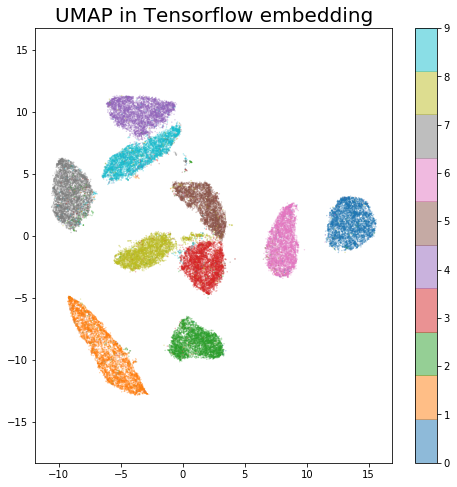

In [22]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [ ]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

In [ ]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

In [ ]:
breakme

### Save output

In [ ]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [ ]:
#output_dir = MODEL_DIR/'projections'/ 'mnist' / 'direct'
#ensure_dir(output_dir)

In [ ]:
#embedder.save(output_dir)

In [ ]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [ ]:
#np.save(output_dir / 'z.npy', z)

### Compare to direct embedding with base UMAP

In [ ]:
from umap import UMAP

In [ ]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

In [ ]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);